# Sentiment Analysis of Drug Reviews & Sentiment Prediction of Reviews

Patient reviews on specific drugs, as well as linked ailments, are included in the dataset, as well as a 10-star patient rating indicating overall patient satisfaction.

Patient reviews on specific drugs, as well as linked ailments, are included in the dataset, as well as a 10-star patient rating indicating overall patient satisfaction. Crawling online pharmaceutical review sites yielded the information. The goal was to do research.

* drug experience sentiment analysis across multiple facets, i.e. sentiments learned on specific aspects such as effectiveness and side effects
* model transferability across domains, i.e. conditions, and 
* model transferability across different data sources (see 'Drug Review Dataset (Druglib.com)').

Ref: https://archive.ics.uci.edu/ml/datasets/Drug+Review+Dataset+%28Drugs.com%29

We plan to look at the various reviews for each condition and drugs; try to analyse the sentiment on a scale of "Positive", "Negative" & "Neutral". We first explore the data, process it in the required fashion, draw some insights by employing NLP techniques and finally model our data to predict outcomes for a particular review.

In [1]:
# Importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from textblob import TextBlob
from  sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
import pdb 
import nltk
from nltk.stem import *
from nltk.corpus import stopwords
import re
import string
from collections import Counter
from gensim import matutils, models
import scipy.sparse
from sklearn.feature_extraction import text 
from bs4 import BeautifulSoup
# from wordcloud import WordCloud
import tqdm
from textblob import TextBlob, Word, Blobber
from nltk.stem import PorterStemmer
nltk.download('wordnet')
nltk.download('omw-1.4')

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sushanthsreenivasa/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/sushanthsreenivasa/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### 1. Exploratory Data Analysis

We first load the data in our pandas dataframe, and try to explore it further. We see that there are 899 "NaN" values for the condition column. 

On further exploration, we see that these columns have relavant drug names but do not have a condition, looking at the histogram, we see that most of these have a very low useful count. Hence, we decide to drop these rows and then proceed further with the analysis.

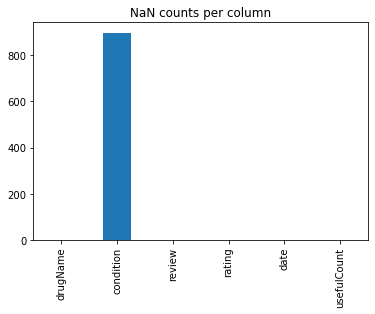

In [93]:
# NaN counts per column
data = pd.read_csv("./drugsCom_raw/drugsComTrain_raw.tsv",  index_col=False, sep='\t')
data.drop(['Unnamed: 0'], axis=1, inplace=True) # drop Unnamed: 0 column
data.isnull().sum().plot(kind='bar')
plt.title("NaN counts per column")
plt.show() 

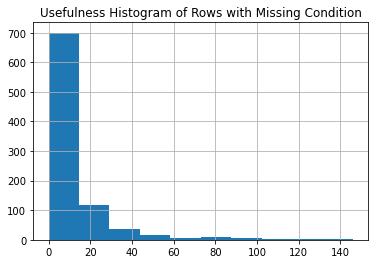

In [3]:
# Nan usefulness
data[data['condition'].isnull()]['usefulCount'].hist()
plt.title("Usefulness Histogram of Rows with Missing Condition")
plt.show()

In [4]:
data.dropna(axis=0, inplace=True) # dropping NaN rows
data.head()

,drugName,condition,review,rating,date,usefulCount
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


Now, we see that the data has 160K rows and 6 columns, the dat types of the columns are displayed below. This will help us further analyze and figure out the best plan of action.

In [5]:
print("Shape of the data:" , data.shape)

Shape of the data: (160398, 6)


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 160398 entries, 0 to 161296
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   drugName     160398 non-null  object 
 1   condition    160398 non-null  object 
 2   review       160398 non-null  object 
 3   rating       160398 non-null  float64
 4   date         160398 non-null  object 
 5   usefulCount  160398 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 8.6+ MB


Just by plain sight, the rating column is mostly positive with a greater number of rows having rating greater than 8. Although, there seems to be a substantial amount of columns with "1" rating.

Text(0.5, 1.0, 'Reviews per Rating')

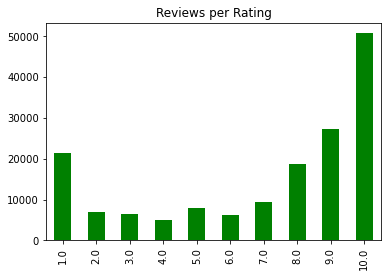

In [7]:
pd.Categorical(data['rating']).value_counts().plot(kind='bar', color = 'green')
plt.title("Reviews per Rating")

Text(0.5, 1.0, 'Drugs for the most number of conditions')

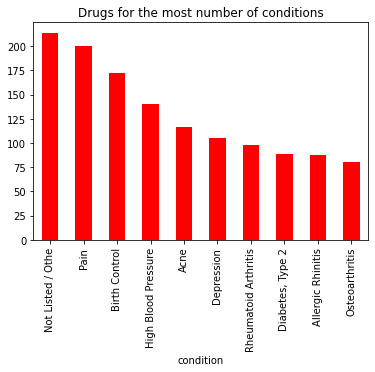

In [8]:
condition = data.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
condition[0:10].plot(kind="bar", color="red")
plt.title("Drugs for the most number of conditions")

On further investigation, we see that there are rows with the condition '3</span> users found this comment helpful.'. This might be an error during data collection and needs to be handled. These rows just have a mean useful rating of about 11 and hence, we decide to drop these rows from our analysis.

In [99]:
data[data['condition'].str.contains('</span> users found this comment helpful.', 
                                    na=False)]['usefulCount'].mean()

11.311111111111112

In [10]:
data.drop(data[data['condition'].str.contains('</span> users found this comment helpful.')].index,
          axis=0, inplace=True) # drop rows

Now, let's look at our review column and figure out how we want to proceed with out text processing pipeline. We can access a few of the reviews and understand how they are represented. 

Looks like the text data has some special characters that need to be removed, and the crawling process has caused * /&#039 * to creep in as a replacement for '. We need to handle these in our cleaning process.

In [64]:
data['review'][1]

'"My son is halfway through his fourth week of Intuniv. We became concerned when he began this last week, when he started taking the highest dose he will be on. For two days, he could hardly get out of bed, was very cranky, and slept for nearly 8 hours on a drive home from school vacation (very unusual for him.) I called his doctor on Monday morning and she said to stick it out a few days. See how he did at school, and with getting up in the morning. The last two days have been problem free. He is MUCH more agreeable than ever. He is less emotional (a good thing), less cranky. He is remembering all the things he should. Overall his behavior is better. \r\nWe have tried many different medications and so far this is the most effective."'

In [12]:
data['review'][2]

'"I used to take another oral contraceptive, which had 21 pill cycle, and was very happy- very light periods, max 5 days, no other side effects. But it contained hormone gestodene, which is not available in US, so I switched to Lybrel, because the ingredients are similar. When my other pills ended, I started Lybrel immediately, on my first day of period, as the instructions said. And the period lasted for two weeks. When taking the second pack- same two weeks. And now, with third pack things got even worse- my third period lasted for two weeks and now it&#039;s the end of the third week- I still have daily brown discharge.\r\nThe positive side is that I didn&#039;t have any other side effects. The idea of being period free was so tempting... Alas."'

We now look at the review column and employ our NLP techniques to remove stopwords and use some regular expressions to clean the data. This will help us make sense of which words mostly correlate to the review's sentiment. 

In [13]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stopwords = stopwords.words('english')
stopwords.remove('not')
stopwords.remove('no')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sushanthsreenivasa/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [75]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "willnot", phrase)
    phrase = re.sub(r"can\'t", "cannot", phrase)
    phrase = re.sub(r"\"", "", phrase)
    phrase = re.sub(r"&#039;", "\'", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", "not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    return phrase

In [76]:
# Combining all the above reviews 
from tqdm import tqdm
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentence in tqdm(text_data):
        sent = decontracted(sentence)
        sent = re.sub(r"http\S+", "", sentence)
        sent = BeautifulSoup(sentence, 'lxml').get_text()
        sent = decontracted(sentence)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [77]:
preprocessed_review = preprocess_text(data['review'].values)
data['processed_review'] = preprocessed_review

100%|██████████| 159498/159498 [00:47<00:00, 3344.76it/s]


In [78]:
def sentiment(rating):

    if rating >= 7:
        return 'Positive'

    elif 4 < rating < 7:
        return 'Neutral'

    elif rating < 5:
        return 'Negative'

<AxesSubplot:>

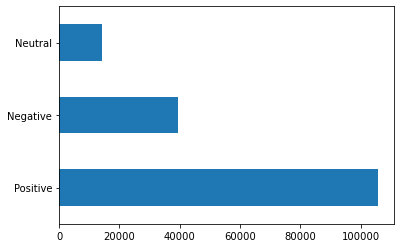

In [79]:
data['ratings_labels'] = data['rating'].apply(sentiment)
data['ratings_labels'].value_counts().plot(kind='barh')

We find out the top 5 drugs with a particular sentiment for a particular condition. We can select the condition from the dropdown.

In [80]:
import ipywidgets as widgets

def plot_top_positive_rated_drugs(condition, sentiment):
    temp = data[(data['condition'] == condition) & (data['ratings_labels'] == sentiment)].groupby(['drugName', 
                                                                                                    'ratings_labels'], as_index=False).agg({"ratings_labels": "count"})
    temp = temp.nlargest(n=10, 
                         columns=['ratings_labels'], 
                         keep='all').sort_values('ratings_labels', ascending=False)
    temp.head()
    temp.plot(kind='barh',y='ratings_labels', x='drugName')

condition = widgets.Dropdown(options=data.condition.unique().tolist(),
                             description="Condition", value='ADHD')
sentiment = widgets.Dropdown(options=data.ratings_labels.unique().tolist(), 
                             description="Sentiment", value='Positive') 
@widgets.interact(Condition = condition, Sentiment = sentiment)
def widget_plotter(Condition, Sentiment):
    plot_top_positive_rated_drugs(Condition, Sentiment)

interactive(children=(Dropdown(description='Condition', index=1, options=('Left Ventricular Dysfunction', 'ADH…

We now look for for words that commonly occur for each of the labels. 

First, we looked at unigrams and figured out that these words occur across the three lables. Then we proceed to look at bigrams, trigrams and later 4-grams. Instinctively most of these phrases appear to be aligned to their corresponding sentiment. 

In [81]:
from collections import defaultdict

df_positive = data[data['ratings_labels'] == "Positive"]
df_negative = data[data['ratings_labels'] == "Negative"]
df_neutral = data[data['ratings_labels'] == "Neutral"]

In [82]:
from plotly import tools
import plotly.offline as py
import plotly.graph_objs as go

# Reference: https://www.kaggle.com/code/chocozzz/recommendation-medicines-by-using-a-review#2.-Date-Preprocessing

def plot_grams(gram_size, gram_text):
## custom function for ngram generation ##
    def generate_ngrams(text, gram_size):
        token = [token for token in text.lower().split(" ") if token != "" if token not in stopwords]
        ngrams = zip(*[token[i:] for i in range(gram_size)])
        return [" ".join(ngram) for ngram in ngrams]

    ## custom function for horizontal bar chart ##
    def horizontal_bar_chart(df, color):
        trace = go.Bar(
            y=df["word"].values[::-1],
            x=df["wordcount"].values[::-1],
            showlegend=False,
            orientation = 'h',
            marker=dict(
                color=color,
            ),
        )
        return trace

    ## Function to get the bar chart
    def get_bar_chart(df):
        freq_dict = defaultdict(int)
        for sent in df["processed_review"]:
            for word in generate_ngrams(sent, gram_size):
                freq_dict[word] += 1
        fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
        fd_sorted.columns = ["word", "wordcount"]
        trace = horizontal_bar_chart(fd_sorted.head(20), 'blue')
        return trace

    ## Get the bar chart for positive
    trace0 = get_bar_chart(df_positive)

    ## Get the bar chart for negative
    trace1 = get_bar_chart(df_negative)

    ## Get the bar chart for neutral
    trace2 = get_bar_chart(df_neutral)

    # Creating three subplots
    fig = tools.make_subplots(rows=3, cols=1, vertical_spacing=0.04,
                              subplot_titles=["Frequent "+gram_text+": Positive", 
                                              "Frequent "+gram_text+": Negative",
                                              "Frequent "+gram_text+": Neutral"])
    fig.append_trace(trace0, 1, 1)
    fig.append_trace(trace1, 2, 1)
    fig.append_trace(trace2, 3, 1)
    fig['layout'].update(height=1200, width=900)
    py.iplot(fig, filename='word-plots')

In [83]:
plot_grams(1, "words")

/Users/sushanthsreenivasa/opt/anaconda3/lib/python3.8/site-packages/plotly/tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [84]:
plot_grams(2, "bi-grams")

In [85]:
plot_grams(3, "tri-grams")

In [86]:
plot_grams(4, "4-grams")

We have now seen which words are phrases are common to our three labels. We can now proceed with our preprocessing steps before we begin to model our data and get some metrics.

In [87]:
data.head()

,drugName,condition,review,rating,date,usefulCount,processed_review,ratings_labels,vader_scores,vader_neg,vader_pos,vader_neu,vader_polarity,ratings_binary,vader_polarity_binary
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27,no side effect take combination bystolic 5 mg ...,Positive,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,0.000,1.000,Neutral,1,0
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192,son halfway fourth week intuniv became concern...,Positive,"{'neg': 0.035, 'neu': 0.756, 'pos': 0.209, 'co...",0.035,0.209,0.756,Neutral,1,0
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17,used take another oral contraceptive 21 pill c...,Neutral,"{'neg': 0.064, 'neu': 0.804, 'pos': 0.131, 'co...",0.064,0.131,0.804,Neutral,0,0
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10,first time using form birth control glad went ...,Positive,"{'neg': 0.044, 'neu': 0.778, 'pos': 0.178, 'co...",0.044,0.178,0.778,Neutral,1,0
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37,suboxone completely turned life around feel he...,Positive,"{'neg': 0.109, 'neu': 0.589, 'pos': 0.302, 'co...",0.109,0.302,0.589,Neutral,1,0


### 2. Feature Engineering & Data Preprocessing

The columns "review", "rating", "date" can be dropped as the will not add further value to our data. We will proceed further without these columns.

The vader package gives us sentiment of a given text, while the rating column already serves this purpose. This can be used as additional features for our prediction. Let's now get these vader values.

In [27]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()
data['vader_scores'] = data['processed_review'].apply(lambda review: sid.polarity_scores(review))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sushanthsreenivasa/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [28]:
def get_score_neg(x):
    return x['neg']

def get_score_neu(x):
    return x['neu']

def get_score_pos(x):
    return x['pos']

data['vader_neg'] = data['vader_scores'].apply(get_score_neg)
data['vader_pos'] = data['vader_scores'].apply(get_score_pos)
data['vader_neu'] = data['vader_scores'].apply(get_score_neu)

In [29]:
def vader_label(x, y, z):
    if (x > y) & (x > z):
        return "Negative"
    elif (y > z) & (y > x):
        return "Positive"
    else:
        return "Neutral"
    
data['vader_polarity'] = data.apply(lambda x: vader_label(x['vader_neg'], x['vader_pos'], x['vader_neu']), axis=1)

Now that we have created the vader features, we shall now look at how they affect our sentiment labels. 

<AxesSubplot:>

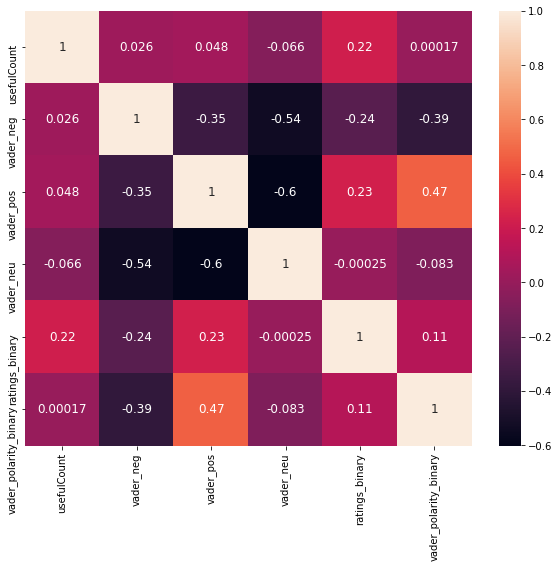

In [30]:
data['ratings_binary'] = data['ratings_labels'].map({'Positive': 1, 'Negative': -1, 'Neutral': 0})
data['vader_polarity_binary'] = data['vader_polarity'].map({'Positive': 1, 'Negative': -1, 'Neutral': 0})

plt.subplots(figsize=(10,8))
sns.heatmap(data[['usefulCount', 'vader_neg', 
                  'vader_pos', 'vader_neu', 'ratings_binary', 'vader_polarity_binary']].corr(),
           annot=True, annot_kws={"size": 12})

Athought there is very low correlation for the the ratings label and the vader scores, there seems to be an overall higher score than the rest. Hence, we will keep these for our modeling. 

In [31]:
# Selecting columns required for modeling
df_model = data[['drugName', 'condition', 'usefulCount', 'processed_review', 
                 'vader_neg', 'vader_pos', 'vader_neu', 'ratings_binary', 'ratings_labels']]

As a word preprocessing step, we now perform stemming and lemmatization for our data.

In [33]:
st = PorterStemmer()
df_model['processed_review'] = df_model['processed_review'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
df_model['processed_review'] = df_model['processed_review'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

In [36]:
df_model.head()

,drugName,condition,usefulCount,processed_review,vader_neg,vader_pos,vader_neu,ratings_binary,ratings_labels
0,Valsartan,Left Ventricular Dysfunction,27,side effect take combin bystol 5 mg fish oil,0.000,0.000,1.000,1,Positive
1,Guanfacine,ADHD,192,son halfway fourth week intuniv becam concern ...,0.035,0.209,0.756,1,Positive
2,Lybrel,Birth Control,17,use take anoth oral contracept 21 pill cycl ha...,0.064,0.131,0.804,0,Neutral
3,Ortho Evra,Birth Control,10,first time use form birth control glad went pa...,0.044,0.178,0.778,1,Positive
4,Buprenorphine / naloxone,Opiate Dependence,37,suboxon complet turn life around feel healthie...,0.109,0.302,0.589,1,Positive


As an exploratory step, we try to replace the drugName and condition columns which have only text into a numeric format. This makes the model not rely entirely on these two columns for prediction of sentiment. 

We made a feature, condition_weights, that takes the number of different drugs associated with that condition and another feature drugName_weights that takes the number of different conditions associated with a particular drug. We should however, check how they correlate with our target before modeling.

In [37]:
condition_weights = {}

for condition in df_model['condition'].unique():
    condition_weights[condition] = df_model[df_model['condition'] == condition]['drugName'].nunique()

In [38]:
drugName_weights = {}

for drugName in df_model['drugName'].unique():
    drugName_weights[drugName] = df_model[df_model['drugName'] == drugName]['condition'].nunique()

In [39]:
df_model['drugName_weights'] = df_model['drugName'].map(drugName_weights)
df_model['condition_weights'] = df_model['condition'].map(condition_weights)

In [40]:
df_model.columns

Index(['drugName', 'condition', 'usefulCount', 'processed_review', 'vader_neg',
       'vader_pos', 'vader_neu', 'ratings_binary', 'ratings_labels',
       'drugName_weights', 'condition_weights'],
      dtype='object')

<AxesSubplot:>

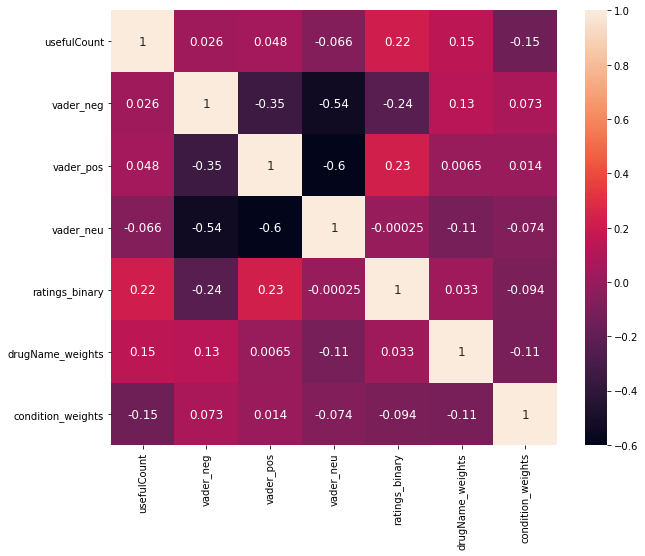

In [41]:
plt.subplots(figsize=(10,8))
sns.heatmap(df_model.corr(),
           annot=True, annot_kws={"size": 12})

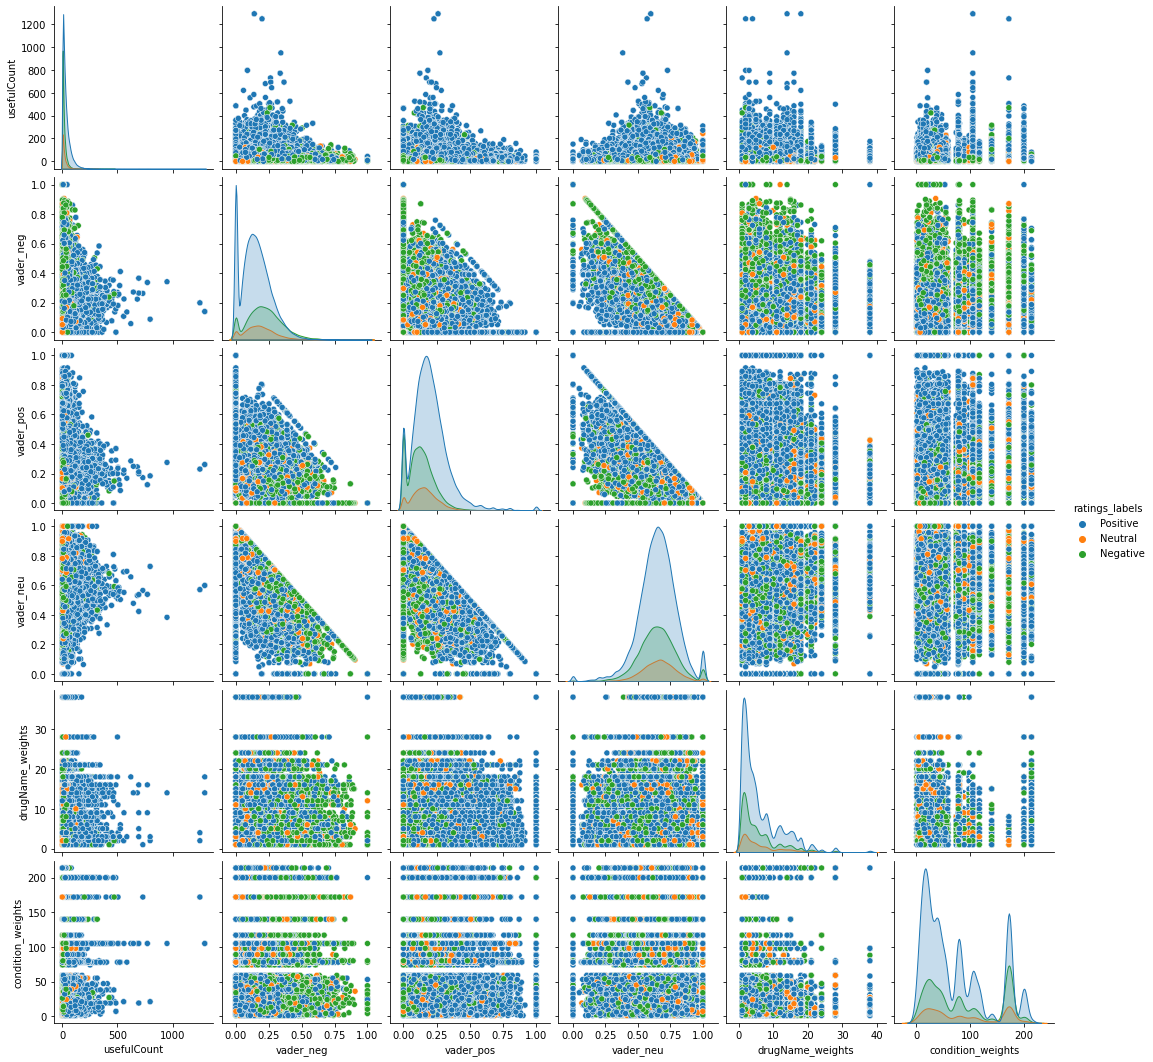

In [91]:
sns.pairplot(df_model, hue='ratings_labels')

The pairplot and the heatmaps tell us that the class labels are not easy to be separated and hence, it might be difficult to model the data with classical machine learning models. We decided to incorporate the Random Forest classifier as ensemble models work well with non easily identifiable label boundaries in n-D space.

In [42]:
df_model.drop(['drugName', 
               'condition', 
               'ratings_binary'], axis = 1, inplace = True) # dropping the non required columns

### 3. Modeling

In [43]:
X = df_model[['usefulCount', 'processed_review', 'vader_neg', 'vader_pos',
       'vader_neu','drugName_weights', 'condition_weights']]
Y = df_model[['ratings_labels']]

In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state = 101)

In [45]:
from sklearn import preprocessing

scaler_drugName_weights = preprocessing.MinMaxScaler()
scaler_condition_weights = preprocessing.MinMaxScaler()

X_train['drugName_weights_scaled'] = scaler_drugName_weights.fit_transform(X_train['drugName_weights'].values.reshape(-1,1))
X_train['condition_weights_scaled'] = scaler_condition_weights.fit_transform(X_train['condition_weights'].values.reshape(-1,1))

X_test['drugName_weights_scaled'] = scaler_drugName_weights.transform(X_test['drugName_weights'].values.reshape(-1,1))
X_test['condition_weights_scaled'] = scaler_condition_weights.transform(X_test['condition_weights'].values.reshape(-1,1))


In [46]:
X_test.drop(['drugName_weights', 'condition_weights'], axis = 1, inplace = True)
X_test.head()

,usefulCount,processed_review,vader_neg,vader_pos,vader_neu,drugName_weights_scaled,condition_weights_scaled
119247,12,hate honestli made crazi recommend,0.484,0.437,0.079,0.081081,0.802817
13957,15,fibromyalgia suffer 10 year,0.500,0.000,0.500,0.351351,0.173709
91642,22,inject close foot surgeri 5th metatars obliqu ...,0.211,0.163,0.626,0.000000,0.934272
26488,54,vesicar work side effect dri mouth sever stop ...,0.407,0.000,0.593,0.027027,0.126761
33980,30,work gave 9 10 get rid acn find small pimpl tw...,0.148,0.206,0.646,0.000000,0.544601


In [47]:
X_train.drop(['drugName_weights', 'condition_weights'], axis = 1, inplace = True)
X_train.head()

,usefulCount,processed_review,vader_neg,vader_pos,vader_neu,drugName_weights_scaled,condition_weights_scaled
8757,62,start use azor 10 40 blood pressur consist 190...,0.121,0.116,0.763,0.000000,0.652582
26169,22,stare belsomra 10mg last week complet 4 night ...,0.042,0.126,0.832,0.000000,0.361502
54183,17,start simvastatin year ago 6 week take medicin...,0.146,0.042,0.812,0.081081,0.065728
66549,7,great frequent migrain,0.000,0.672,0.328,0.081081,0.192488
132771,12,blood work x ray amp ct scan offici pneumonia ...,0.124,0.336,0.540,0.297297,0.145540


In [48]:
scaler_usefulCount = preprocessing.MinMaxScaler()

X_train['usefulCount_scaled'] = scaler_usefulCount.fit_transform(X_train['usefulCount'].values.reshape(-1,1))
X_test['usefulCount_scaled'] = scaler_usefulCount.transform(X_test['usefulCount'].values.reshape(-1,1))

In [49]:
X_train.drop(['usefulCount'], axis = 1, inplace = True)
X_train.head()

,processed_review,vader_neg,vader_pos,vader_neu,drugName_weights_scaled,condition_weights_scaled,usefulCount_scaled
8757,start use azor 10 40 blood pressur consist 190...,0.121,0.116,0.763,0.000000,0.652582,0.048025
26169,stare belsomra 10mg last week complet 4 night ...,0.042,0.126,0.832,0.000000,0.361502,0.017041
54183,start simvastatin year ago 6 week take medicin...,0.146,0.042,0.812,0.081081,0.065728,0.013168
66549,great frequent migrain,0.000,0.672,0.328,0.081081,0.192488,0.005422
132771,blood work x ray amp ct scan offici pneumonia ...,0.124,0.336,0.540,0.297297,0.145540,0.009295


In [50]:
X_test.drop(['usefulCount'], axis = 1, inplace = True)
X_test.head()

,processed_review,vader_neg,vader_pos,vader_neu,drugName_weights_scaled,condition_weights_scaled,usefulCount_scaled
119247,hate honestli made crazi recommend,0.484,0.437,0.079,0.081081,0.802817,0.009295
13957,fibromyalgia suffer 10 year,0.500,0.000,0.500,0.351351,0.173709,0.011619
91642,inject close foot surgeri 5th metatars obliqu ...,0.211,0.163,0.626,0.000000,0.934272,0.017041
26488,vesicar work side effect dri mouth sever stop ...,0.407,0.000,0.593,0.027027,0.126761,0.041828
33980,work gave 9 10 get rid acn find small pimpl tw...,0.148,0.206,0.646,0.000000,0.544601,0.023238


In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

tfidf_drugName = TfidfVectorizer(min_df=10, ngram_range=(1,4))
X_train_review = tfidf_drugName.fit_transform(X_train['processed_review'].values)
X_train_review.shape

(106863, 89874)

In [52]:
X_test_review = tfidf_drugName.transform(X_test['processed_review'].values)
X_test_review.shape

(52635, 89874)

In [53]:
X_train.drop(['processed_review'], axis = 1, inplace = True)
X_train.head()

,vader_neg,vader_pos,vader_neu,drugName_weights_scaled,condition_weights_scaled,usefulCount_scaled
8757,0.121,0.116,0.763,0.000000,0.652582,0.048025
26169,0.042,0.126,0.832,0.000000,0.361502,0.017041
54183,0.146,0.042,0.812,0.081081,0.065728,0.013168
66549,0.000,0.672,0.328,0.081081,0.192488,0.005422
132771,0.124,0.336,0.540,0.297297,0.145540,0.009295


In [54]:
X_test.drop(['processed_review'], axis = 1, inplace = True)
X_test.head()

,vader_neg,vader_pos,vader_neu,drugName_weights_scaled,condition_weights_scaled,usefulCount_scaled
119247,0.484,0.437,0.079,0.081081,0.802817,0.009295
13957,0.500,0.000,0.500,0.351351,0.173709,0.011619
91642,0.211,0.163,0.626,0.000000,0.934272,0.017041
26488,0.407,0.000,0.593,0.027027,0.126761,0.041828
33980,0.148,0.206,0.646,0.000000,0.544601,0.023238


In [55]:
from scipy.sparse import hstack

train_vector = hstack((X_train, X_train_review)).tocsr()
test_vector = hstack((X_test, X_test_review)).tocsr()

In [56]:
test_vector.shape[1] == train_vector.shape[1] 

True

Selecting the required columns for modelling the data

Splitting our data into test and train set which would be used for model building and testing how well the model performs on unseen test data

Vectorizing the textual user comments for input of the model. We are using CountVectorizer() to transform our text to numerical representation.

Since our classes are imbalanced we are using random forest model to train our model. We used GridsearchCV to find the best parameters for Random forest model for best accuracy.

In [57]:
rf = RandomForestClassifier(bootstrap=True, criterion='gini', max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=101,
                       verbose=0, warm_start=False)    
rf.fit(train_vector, y_train)

RandomForestClassifier(n_estimators=200, random_state=101)

In [58]:
# param_grid = {'n_estimators': [100,200,1000],
#                'max_features': ['auto', 'sqrt'],
#                'max_depth': [2,4,10,20],
#                'min_samples_split': [2, 5],
#                'min_samples_leaf': [1, 2],
#                'bootstrap': [True, False]}
# rf_Model = RandomForestClassifier()
# from sklearn.model_selection import GridSearchCV
# rf_Grid = GridSearchCV(estimator = rf_Model, param_grid = param_grid, cv = 3, verbose=2, n_jobs = 4)
# rf_Grid.fit(X_train_vectorized, y_train)

Predicting on test data and generating the confusion matrix to observe the performance for each label category

In [59]:
from sklearn.metrics import accuracy_score
predictions = rf.predict(test_vector)
print('Acurracy: ', accuracy_score(y_test, predictions))

Acurracy:  0.8375605585636934


In [60]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

    Negative       0.94      0.58      0.72     13091
     Neutral       1.00      0.41      0.58      4737
    Positive       0.81      0.99      0.89     34807

    accuracy                           0.84     52635
   macro avg       0.92      0.66      0.73     52635
weighted avg       0.86      0.84      0.82     52635



In [61]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, predictions, labels=['Negative', 'Neutral', 'Positive'])
cm

array([[ 7614,     0,  5477],
       [  250,  1923,  2564],
       [  257,     2, 34548]])

In [62]:
cm_df = pd.DataFrame({'negative': [cm[0][0], cm[1][0], cm[2][0]], 
                 'neutral': [cm[0][1], cm[1][1], cm[2][1]], 
                 'positive': [cm[0][2], cm[1][2], cm[2][2]]})
cm_df.index = ['negative', 'neutral', 'positive']
cm_df

,negative,neutral,positive
negative,7614,0,5477
neutral,250,1923,2564
positive,257,2,34548


Text(51.0, 0.5, 'Predicted Labels')

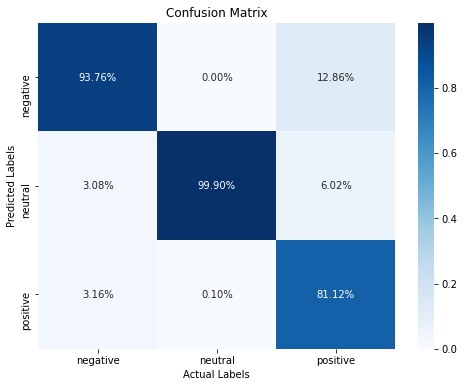

In [63]:
fig, ax = plt.subplots(figsize=(8,6))  

sns.heatmap(cm_df/np.sum(cm_df),
            annot=True, 
            fmt='.2%', 
            cmap='Blues', 
            ax=ax)

plt.title('Confusion Matrix')
plt.xlabel("Actual Labels")
plt.ylabel("Predicted Labels")